<a href="https://colab.research.google.com/github/AusafMo/ResNet50-VGG16-MRI_Tumor_Classification/blob/main/TumorTestResnet50andVGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Setting Up for direct kaggle Dataset access**
<br>
<li>These following lines of codes allows us to directly download and use the kaggle dataset in our colab's <b> <i> session </i> </b> storage.

In [6]:
# install kaggle library
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# make a directory named kaggle
!mkdir ~/.kaggle

In [3]:
# MAKE SURE TO UPLOAD THE JSON to the session storage or LOAD the JSON from Google Drive
# copy the api key file into the kaggle directory
# !cp kaggle.json ~/.kaggle/ ( uncomment this if you are uploading the json in session stotrage )


# for Convinience I am loading the JSON from the drive 
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [4]:
# give the required permission(s) to the JSON file
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
# Download the kaggle dataset
"""
The format of the command is as follows:
!kaggle CATEGORY download URL_TRIMMED_FROM_THE_DATAUPLOADER_USERID
  example :
  in this notebook we will use https://www.kaggle.com/datasets/denizkavi1/brain-tumor dataset,
  so now, this dataset belongs to the category 'datasets', it may however be a 'competions'
  dataset.
  so the url from 'denizkavi' is trimmed.
"""
! kaggle datasets download denizkavi1/brain-tumor

 98% 688M/700M [00:07<00:00, 149MB/s]
100% 700M/700M [00:07<00:00, 98.5MB/s]


**Unzipping the file downloaded**

In [6]:
import zipfile
import os

# I am prefering to extract the file to the session storage so to save the Drive Space.
zip_ref = zipfile.ZipFile('/content/brain-tumor.zip', 'r') # Opens the zip file in read mode
zip_ref.extractall('/brain') # Extracts the file into the '/brain' folder
zip_ref.close()

**Import Dependencies**


In [7]:
import torch 
from collections import Counter
import pandas as pd
import plotly.express as px
from sklearn.model_selection import train_test_split
import os
from glob import glob
import warnings
warnings.filterwarnings('ignore', category = FutureWarning)

# Data Manipulation Tools
import numpy as np
import pandas as pd
import os

# Image manipulation 
from PIL import Image

from timeit import default_timer as timer

# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 16


**Creating and Restructering Directories** 

In [8]:
# Root ImagePath prefix
ImagePath = f"/brain/"

In [9]:
# we will iterate for each folder(s) ( these folders here essentially denotes the categories of glucomas/dataset )
from glob import glob
types = glob(ImagePath + "*")

In [10]:
print(types)

['/brain/3', '/brain/2', '/brain/1']


In [11]:
# Lets make a dataframe to store the PATHS for images, we will again use glob to achieve this

filedf = pd.DataFrame()

for typ in types :
  image = glob( typ + "/*")
  tempdf = pd.DataFrame( {'imagepath' : image, 'types' : typ.split("/")[-1]} )
  filedf = pd.concat( [filedf, tempdf] ) # we may have used 'Append' however its computationally intensive and about to be depracated

In [12]:
# I want to keep the track of the types for convenience so I'm adding a mapping
TypeMap = { '1': 'Meningioma',
            '2' : 'Glioma',
            '3' : 'Pituitary tumor'} 

# Adding this mapping to filedf
filedf['TumorName'] = filedf['types'].map(TypeMap)

# Note that we will not make any changes to the original dataset now, rather we will create new ones from now on
# Group the data by 'types' column
grouped = filedf.groupby('types')

# Count only the 'imagepath' column for each group
counted = grouped['imagepath'].count()

# Rename the 'imagepath' column to 'cnt'
renamed = counted.rename('cnt')

# Reset the index
reset = renamed.reset_index()

# Add the TumorName column to the resulting DataFrame
reset['TumorName'] = reset['types'].map(TypeMap)

# Sort the DataFrame by the 'cnt' column in descending order
sorted_df = reset.sort_values(by='cnt', ascending=False)

# Assign the resulting DataFrame to the 'gby_cnt' variable
grouped_count = sorted_df

grouped_count.head()

,types,cnt,TumorName
1,2,1426,Glioma
2,3,930,Pituitary tumor
0,1,708,Meningioma


In [13]:
# plot a simple histogram to show counts
fig = px.bar( grouped_count, x = 'TumorName', y = 'cnt', color = 'types', title = 'Counts from Each Type')
fig.show()

In [14]:
!mkdir ouptputs # Create a Outputs Directory

In [15]:
# if you want to keep the classes list for some reason
# grouped_count.to_csv(f"outputs/types.csv", index = None)

**Let's Check some Samples**

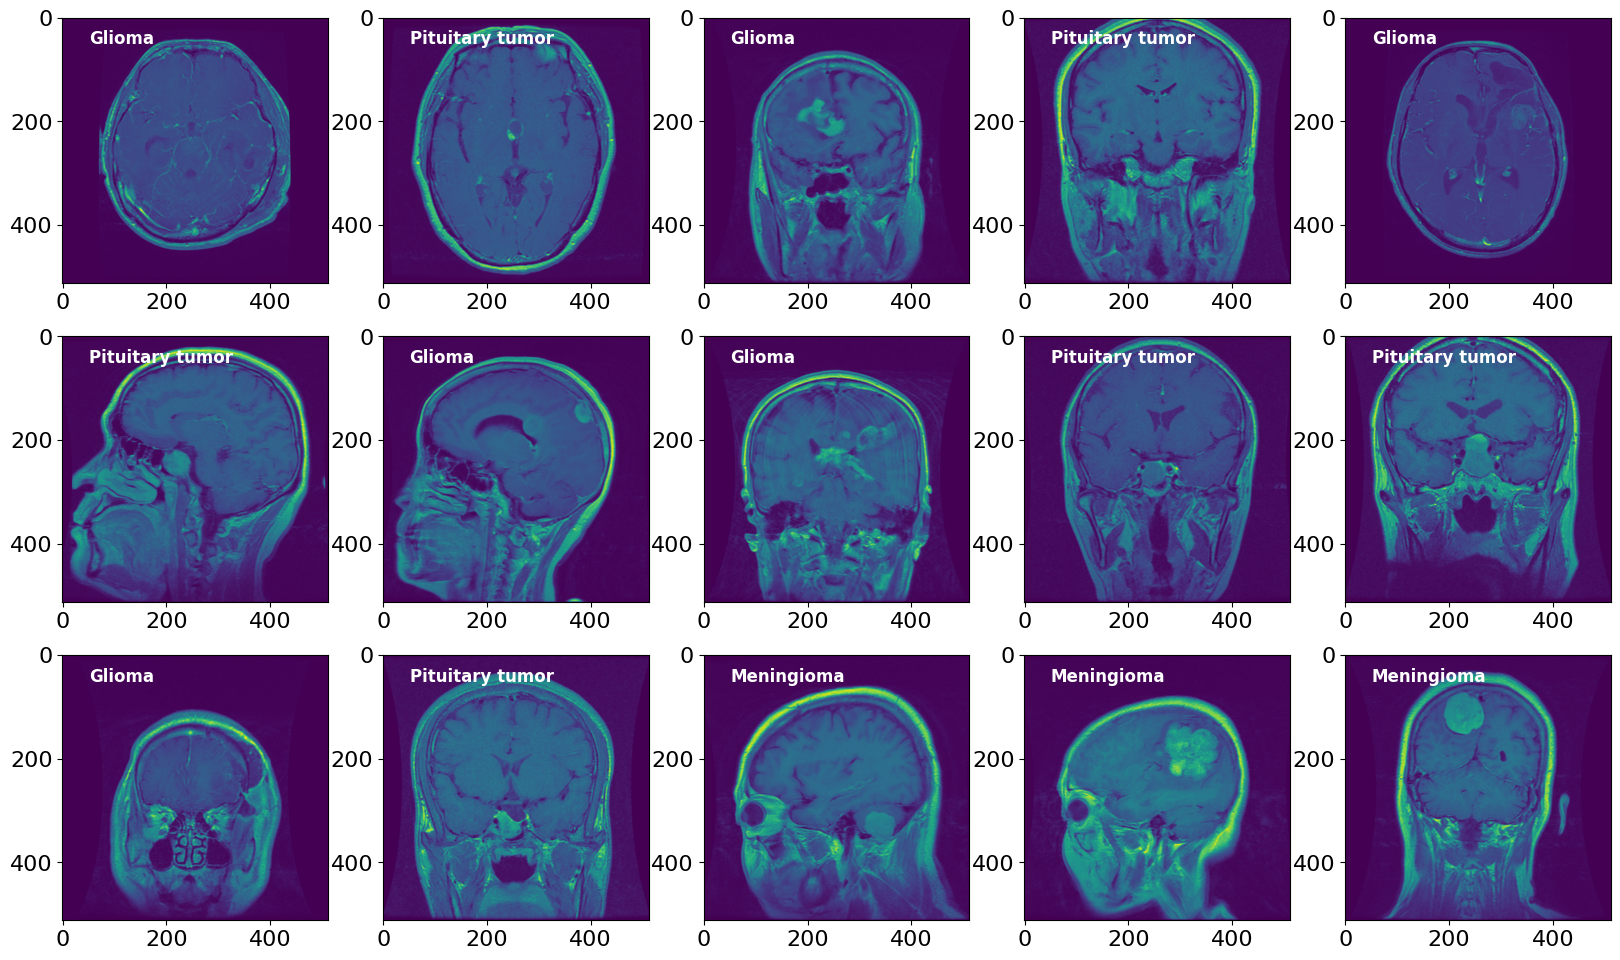

In [16]:
""" 
Now we will look at some samples of the dataset.
    To be specific this code does the following steps :
      1) takes path of a single random sample from filedf
      2) finds the corresponding TumorName by looking at its folder name and its mapping in the TypeMap
      3) opens the image thats at the path
      4) creates a plot of 5*5 subplots
      5) annotates the image
      6) displays the images
"""

plt.figure( figsize = (20,20) )

for i in range(15) :
  path = filedf.sample(1)['imagepath'].values[0]
  types = TypeMap[path.split("/")[2]]
  example = Image.open(path)
  ax = plt.subplot(5,5, i+1)
  ax.annotate( types, xy = (0.1, 0.9), xycoords = 'axes fraction', color = 'white', weight = 'heavy', size = 12 )
  ax.imshow(example)

plt.show()

*Just Double-Checking*

In [17]:
print("Dataframe length :", len(filedf))

Dataframe length : 3064


In [18]:
filedf.TumorName.value_counts().head(10)

Glioma             1426
Pituitary tumor     930
Meningioma          708
Name: TumorName, dtype: int64

In [19]:
print("Total Samples : ", filedf.types.value_counts().sum())

Total Samples :  3064


**Splitting the Dataset into Train, Test, and Val**

1) first method

In [20]:
# # One way to split your data into train, test and val in almost one line is the following library
# !pip install split-folders

# import splitfolders

# """ 
# This splits the folders (stratifi-cally (if thats a word)), also you can look here = https://pypi.org/project/split-folders/ 
# """
# import splitfolders
# splitfolders.ratio('/brain', output="/tumor", seed=1337, ratio=(.7, 0.2,0.1))

# # However i will not use this in this code for comprehensiveness


**2) Full method** <br>
We will perform two splits on the original dataframe <br>
   &nbsp; &nbsp; &nbsp; 1) split it into train and test. <br>
   &nbsp; &nbsp; &nbsp;2) now we perform second split on test set to get a new <b> Test </b> set as well as a new Validation set.

  
  <b> Note : that X_test and Y_test in the 2nd split will be reassigned, it may cause confusion for the first time.</b>

  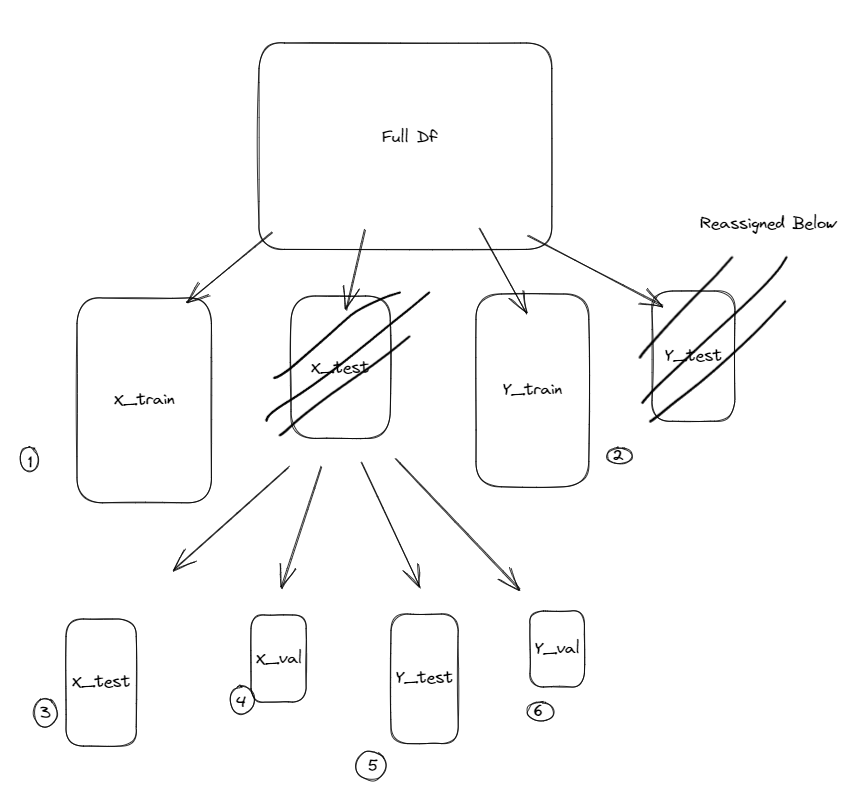


In [21]:

X_train, X_test, Y_train, Y_test = train_test_split(
    filedf, filedf['types'], stratify = filedf['types'], test_size = 0.4
)

X_test, X_val, Y_test, Y_val = train_test_split(
    X_test, X_test['types'], stratify = X_test['types'], test_size = 0.5
)

In [22]:
len(X_train) == len(Y_train) and len(X_test) == len(Y_test)

True

In [23]:
# Now, we will tag the splitted datasets with their purpose or rather 'use';
X_train['use'] = 'train'
X_val['use'] = 'val'
X_test['use'] = 'test'

In [24]:
# concatenate the X datasets, let it be fulldf
fulldf = pd.concat([X_train, X_test, X_val])

In [25]:
fulldf.use.value_counts()

train    1838
test      613
val       613
Name: use, dtype: int64

In [26]:
fulldf.head()

,imagepath,types,TumorName,use
1078,/brain/2/75.png,2,Glioma,train
876,/brain/3/2101.png,3,Pituitary tumor,train
324,/brain/3/941.png,3,Pituitary tumor,train
306,/brain/1/2882.png,1,Meningioma,train
751,/brain/3/1480.png,3,Pituitary tumor,train


**Baseline Accuracy** <br>
Essentially which classes are dominant. <br>
How well a trivial model will perform on the dataset irrelevant of any Input.

In [27]:
fulldf.types.value_counts()[0] / len(fulldf)

0.4654046997389034

**Creating Train, Test and Validation Folders**
<br>
Now, remember we could always do this with split-folders library, but for now we will go ahead and do it.

In [28]:
## for any repeated notebook runs, only has any effects if makedirectory ahead was executed once
!rm -rf data # make a data directory
!rm -rf data/ # remove any subdirectories forcefully
!rm -rf data/train
!rm -rf data/test
!rm -rf data/val


# runs always
!mkdir data/
!mkdir data/train
!mkdir data/test
!mkdir data/val

# Directories are blank right now

In [29]:
fulldf.TumorName.unique()

array(['Glioma', 'Pituitary tumor', 'Meningioma'], dtype=object)

In [30]:
# make classes folder within train, test and val folders
for TumorType in fulldf.types.unique():
  os.system(f"mkdir data/train/'{TumorType}'")
  os.system(f"mkdir data/test/'{TumorType}'")
  os.system(f"mkdir data/val/'{TumorType}'")

In [31]:
"""
Now, we will copy the files from original location to their
correspoinding folders based on their uses, that is test, train or val
"""

for i, row in fulldf.iterrows(): # returns an iter of (index, rows)
  # Tumor Category
  typ = row['types']

  # section is whether its train, test or val
  section = row['use']

  #input filepath to copy from
  ipath = row['imagepath']

  #output filepath to paste to ( we are creating the destination path)
  opath = ipath.replace(f"/brain/", f"data/{section}/")

  # finally copying the files from 'ipath' to 'opath'
  os.system(f"cp '{ipath}' '{opath}'")

# **Data Preprocessing**

**Transorms** <br>
In order to use our images with a network trained on the Imagenet dataset, we need to preprocess our images in the same way as the Imagenet network.

Usually the following transforms are done for ResNet datasets : 

1. Resize: The input images are resized to a fixed size to ensure that all images have the same dimensions.

2. Random crop: During training, a random crop of the resized image is taken to augment the dataset and make the model more robust to different image sizes.

3. Random horizontal flip: The images are randomly flipped horizontally during training to augment the dataset and improve the model's performance.

4. ToTensor: Convert the image to a PyTorch tensor, as PyTorch models work with tensors as input.

5. Normalize: Normalize the pixel values of the image to have zero mean and unit variance. This helps in faster convergence and better performance of the model.

Importing Dependencies

In [32]:
import torch
from collections import Counter
import pandas as pd
import plotly.express as px
from sklearn.model_selection import train_test_split
import os
from glob import glob
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision import models
import torch.nn as nn

from torchvision import transforms, datasets, models
import torch
from torch import optim, cuda
from torch.utils.data import DataLoader, sampler
import torch.nn as nn
import numpy as np
import tqdm

In [33]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Data science tools
import numpy as np
import pandas as pd
import os

# Image manipulations
from PIL import Image

from timeit import default_timer as timer

# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 14

In [34]:
from torch import Tensor, nn
from torch.nn.functional import interpolate

imshow function for tensor

In [35]:
def imshow_tensor(image, ax = None, title = None):
  """ Imshow for tensor 
    Args: 
    image: A PyTorch tensor of the image to be displayed
    ax:    An optional matplotlib axis object to be used for displaying the image.
    title: An optional title to be displayed above the image.

    Returns:
    plot and image
    displays the image
  """
  if ax is None :
    fig, ax = plt.subplots()

    # Set the color channel as the third dimension because,
    # imshow expects(heigth, width, channel) whereas PyTorch represents img as (channels, height, width)
  image = image.numpy().transpose((1, 2, 0))

  # Reverse the preprocessing steps to denormalize the img
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  image = std * image + mean # Undoing the normalization

  # clip the image pixel values
  image = np.clip(image, 0, 1)

  ax.imshow(image)
  plt.axis('off')

  return ax, image


In [36]:
traindir = f"data/train"
validdir = f"data/val"
testdir = f"data/test"

In [37]:
os.listdir('data/train/')

['3', '2', '1']

**Code to deal with GPU**

In [38]:
save_file_name = f'resnet50-transer.pt'
checkpoint_path = f'resnet50-transer.pth'

# Changes for hardware

batch_size = 512

multi_gpu = False ## I am running this on colab, i dont particularly need to handle multiple GPU, but its neverthless good to have

# whether to train on a gpu
train_on_gpu = cuda.is_available()
print(f'Train on GPU : {train_on_gpu}' )

# Number of GPU's

if train_on_gpu:
  gpu_count = cuda.device_count()
  print(f'{gpu_count} gpus detected.')
  if gpu_count > 1:
    multi_gpu = True
  else :
    multi_gpu = False

print(train_on_gpu, multi_gpu)

Train on GPU : True
1 gpus detected.
True False


**Image Transforms**

---
In this image_transforms dictionary we define a list of transformations to be applied on three different sets of train, test and val before they are fed into the model during training. These transforms should be along the lines we looked before. <br>
**transforms.Compose :** allows us to define multiple image transformations sequentially into a pipeline, takes multiple image transformation and returns a single transformation object used for preprocessing data. <br>
**what is Augmentation :** when we artificially inflate the datapoints in the datasets by applying random transforms to the input, thus increasing the input size as well as making the model more robust to any variations in the actual input given to predict.

In [39]:
image_transforms = {
    # Train uses data augmentation 
    'train' : transforms.Compose([
        transforms.RandomResizedCrop( size = 256, scale = (0.8, 1.0)),
        transforms.RandomRotation(degrees = 30),
        transforms.ColorJitter(),
        transforms.CenterCrop( size = 224 ), # ImageNet Standard
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                            [0.229, 0.224, 0.225]) # ImageNet Standard
    ]),
    
    # Validation doesnt use augmentaion
    'valid' : transforms.Compose([
        transforms.Resize( size = 256 ),
        transforms.CenterCrop( size = 224 ),
        transforms.ToTensor(),
        transforms.Normalize( [0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    
    # Test does not use Augmentation 
    'test' : transforms.Compose([
        transforms.Resize(size = 256),
        transforms.CenterCrop(size = 224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

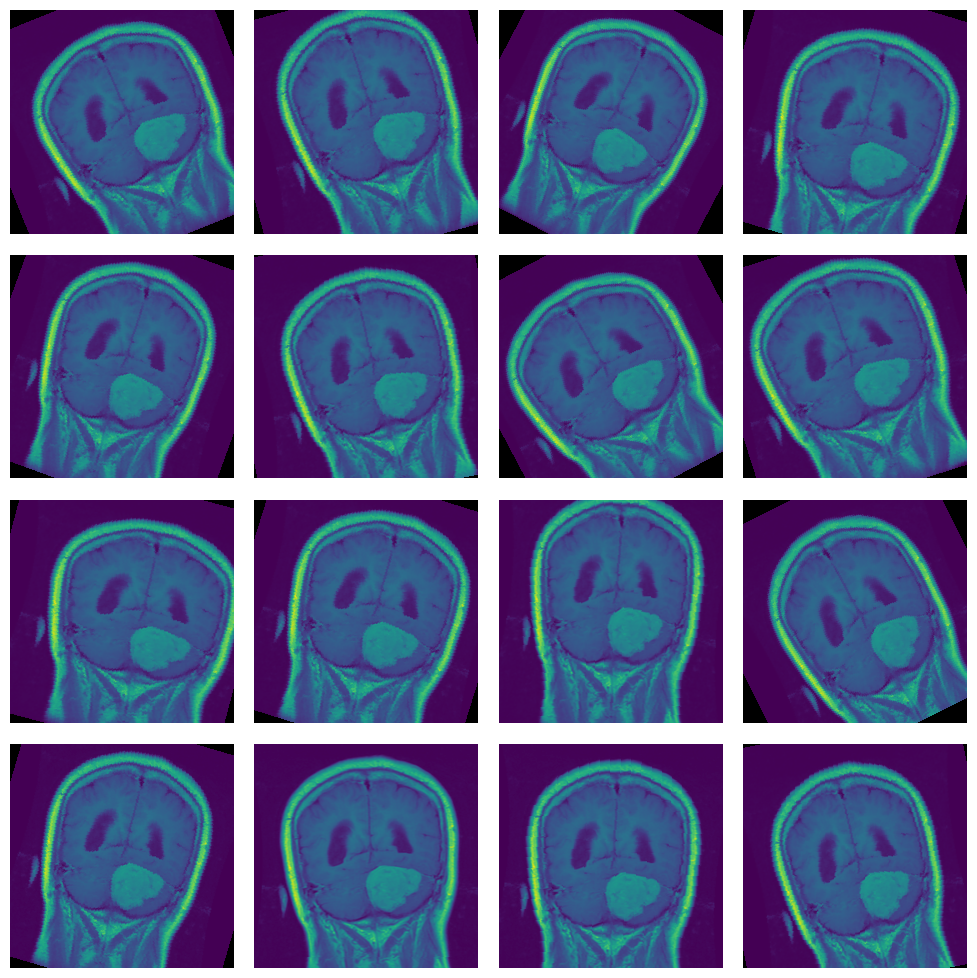

In [40]:
ex_img = Image.open('/content/data/train/1/2303.png').convert('RGB') # Omit the Convert('RGB') if you are working with JPEGs1
# print(np.array(ex_img).shape, type(ex_img))

trans = image_transforms['train']

plt.figure(figsize = (10,10) )

for i in range(16):
  ax = plt.subplot( 4, 4, i+1)
  img = trans(ex_img)
  _ = imshow_tensor(img, ax = ax)

plt.tight_layout()

## **Data Loaders**
---
Dataloaders help us to automate and efficiently load the data into a model, now why do we need them in the first place? <br>
While working with a large enough dataset, even in the colab workspace the default resources may exhaust, the RAM (or memory) in particular. <br>
So dataloaders comes in clutch for parellelly loading the data by batching the huge input dataset size into smaller batches. <br>
Moreover they apply the transformations before loading the data into the model.


In [41]:
""" 
Now we will create a dictionary with 3 torchvision.ImageFolder object,
for 3 keys of train, valid, and test we have a ImageFolder object,
this ImageFolder object expects 2 arguments, a root parameter which expects directorypath from where the image is to be taken,
a transform parameter which expects a transform object consisting of a sequence of transformations to be applied to all the images in the root directory 
"""
data = {
    'train' : datasets.ImageFolder( root = traindir, transform = image_transforms['train']),
    'valid' : datasets.ImageFolder( root = validdir, transform = image_transforms['valid']),
    'test'  : datasets.ImageFolder( root = testdir, transform = image_transforms['test'])
}

# Data Loader iterators, make sure to shuffle
dataloaders = {
    'train' : DataLoader( data['train'], batch_size = batch_size, shuffle = True, num_workers = 0),
    'val' : DataLoader( data['valid'], batch_size = batch_size, shuffle = True, num_workers = 0),
    'test' : DataLoader( data['test'], batch_size = batch_size, shuffle = True, num_workers = 0)
}

In [42]:
# Iterate trhough the dataloader once 
"""
The next(trainiter) returns two things :
1) features : a (batch_size, channel, heigth, width) tensor container 'batch_size' number of images
2) labels   : a (batch_size,) vector with the true labels of of respective images in features
"""

trainiter = iter(dataloaders['train'])
features, labels = next(trainiter)
features.shape, labels.shape

(torch.Size([512, 3, 224, 224]), torch.Size([512]))

In [43]:
categories = []
for d in os.listdir(traindir):
  categories.append(d)

n_classes = len(categories)
print(f'There are {len(categories)} calsses of tumor.')

There are 3 calsses of tumor.


In [44]:
# Mapping of index to class and class to index

class_to_idx = TypeMap
idx_to_class = {
    idx: class_
    for class_, idx in TypeMap.items()
}
print(class_to_idx)
print(idx_to_class)

{'1': 'Meningioma', '2': 'Glioma', '3': 'Pituitary tumor'}
{'Meningioma': '1', 'Glioma': '2', 'Pituitary tumor': '3'}


# **Model**

---
We will be using ResNet50 in this notebook. <br>
We will perform the following tasks : 

1.   Intitialize a pretrained ResNet50 Model from torchvision package, this model has been trained for basic features for image classification.
2.   We will freeze the model weights, why ? beacause we already have a pretrained model (which is enough for us in this case) so we dont want the weights of the layers to change while training the model.
3. We will define a new fully connected layer ( this is the last layer )
4. Now we will set the criterians and optimizers
5. we will create a train function to train the model



In [45]:
# Model
model = models.resnet50( weights = 'ResNet50_Weights.DEFAULT')

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 239MB/s]


In [ ]:
# Freeze the Model weights
for param in model.parameters():
  param.requires_grad = False

print(model)

In [47]:
# here we are saving the number of in_features of fully connected last layer, this will be useful ahead while defining new fc layer
n_input = model.fc.in_features 

**Defining new FC**

In [48]:
model.fc = nn.Sequential(
                         nn.Linear(n_input, 256),  # 1st Linear Layer of taking n_inputs, and outputing 256 sized tensor
                         nn.ReLU(),                # a ReLu activation function is applied to the output of the 1st Linear Layer
                         nn.Dropout(0.4),          # a DropOut Layer, which randomly assigns 40% of the output as zero to prevent OverFitting.
                         nn.Linear(256, n_classes),# 2nd Linear Layer of taking 256 input and outputs n_classes ( in this case 3)
                         nn.LogSoftmax(dim = 1)    # a LogSoftMax function
)

In [49]:
model.fc

Sequential(
  (0): Linear(in_features=2048, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.4, inplace=False)
  (3): Linear(in_features=256, out_features=3, bias=True)
  (4): LogSoftmax(dim=1)
)

In [50]:
total_params, total_trainable_params = 0, 0

for p in model.parameters():
  total_params += p.numel()
  if p.requires_grad :
    total_trainable_params += p.numel()

print(str(total_params) + ' total number of parameter out of which ' + str(total_trainable_params) + ' are trainable parameters.')

24033347 total number of parameter out of which 525315 are trainable parameters.


In [51]:
# checking if the training should be on gpu, if yes, then the model is moved to gpu device, and if multiple gpus are present, then the training is done parallely
if train_on_gpu :
  model = model.to('cuda')
if multi_gpu :
  model = nn.DataParallel(model)

In [52]:
if multi_gpu:
    print(model.module.fc)
else:
    print(model.fc)

Sequential(
  (0): Linear(in_features=2048, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.4, inplace=False)
  (3): Linear(in_features=256, out_features=3, bias=True)
  (4): LogSoftmax(dim=1)
)


In [53]:
model.class_to_idx = idx_to_class
model.idx_to_class = class_to_idx

list(model.idx_to_class.items())

[('1', 'Meningioma'), ('2', 'Glioma'), ('3', 'Pituitary tumor')]

**We Now Define the Loss function and Optimizer**

---

For now we will use the  Negative Log Likelyhood Loss function, which is to be minimized by the Optimizer we chose which is Adam. <br>
Optims task is to update the models parameters with respect to the the loss function to minimize the loss function.

In [54]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())

In [55]:
for p in optimizer.param_groups[0]['params']:
  if p.requires_grad:
    print(p.shape)

torch.Size([256, 2048])
torch.Size([256])
torch.Size([3, 256])
torch.Size([3])


**The Train Function**

In [57]:
def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_file_name,
          max_epochs_stop=3,
          n_epochs=20,
          print_every=1):
    """Train a PyTorch Model

    Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    history = []

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for :  {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')

    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        # Set to training
        model.train()
        start = timer()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            # Tensors to gpu
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            # Clear the previous epochs gradients
            optimizer.zero_grad()

            # Predicted outputs are log probabilities
            # Due to the fc layer the predicted outputs are probabilities in log or logits
            output = model(data)

            # Loss of predicted outputs and target labels
            loss = criterion(output, target)

            # backpropagation of loss
            loss.backward()

            # Update the parameters based on the computed gradients and optimizers learning rate
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))

            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            
            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)

            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():
                # Set to evaluation mode
                model.eval()

                # Validation loop
                for data, target in valid_loader:
                    # Tensors to gpu
                    if train_on_gpu:
                        data, target = data.cuda(), target.cuda()

                    # Forward pass
                    output = model(data)

                    # Validation loss
                    loss = criterion(output, target)
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)

                    # Calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))
                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * data.size(0)

                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                # Calculate average accuracy
                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                history.append([train_loss, valid_loss, train_acc, valid_acc])

                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f}        \tValidation Loss: {valid_loss:.4f}'
                    )
                    print(
                        f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                    )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save model
                    torch.save(model.state_dict(), save_file_name)
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                        )
                        total_time = timer() - overall_start
                        print(
                            f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                        )

                        # Load the best state dict
                        model.load_state_dict(torch.load(save_file_name))

                        # Attach the optimizer
                        model.optimizer = optimizer

                        # Format history
                        history = pd.DataFrame(
                            history,
                            columns=[
                                'train_loss', 'valid_loss', 'train_acc',
                                'valid_acc'
                            ])
                        return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch.'
    )
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history

In [58]:
model, history = train(
    model,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['val'],
    save_file_name = save_file_name,
    max_epochs_stop = 3,
    n_epochs = 30,
    print_every = 1)

Starting Training from Scratch.


Epoch: 0 	Training Loss: 0.9874        	Validation Loss: 1.0485
		Training Accuracy: 48.75%	 Validation Accuracy: 46.66%

Epoch: 1 	Training Loss: 0.7448        	Validation Loss: 0.9384
		Training Accuracy: 69.64%	 Validation Accuracy: 52.53%

Epoch: 2 	Training Loss: 0.6025        	Validation Loss: 0.8090
		Training Accuracy: 72.80%	 Validation Accuracy: 67.54%

Epoch: 3 	Training Loss: 0.5226        	Validation Loss: 0.6761
		Training Accuracy: 78.02%	 Validation Accuracy: 77.00%

Epoch: 4 	Training Loss: 0.4707        	Validation Loss: 0.5839
		Training Accuracy: 80.25%	 Validation Accuracy: 81.57%

Epoch: 5 	Training Loss: 0.4350        	Validation Loss: 0.5205
		Training Accuracy: 81.77%	 Validation Accuracy: 84.67%

Epoch: 6 	Training Loss: 0.4138        	Validation Loss: 0.4689
		Training Accuracy: 82.43%	 Validation Accuracy: 85.64%

Epoch: 7 	Training Loss: 0.3904        	Validation Loss: 0.4337
		Training Accuracy: 84.22%	 Validation Accuracy

**VGG16 Model**

In [103]:
model2 = models.vgg16( weights = 'VGG16_Weights.DEFAULT')

In [104]:
# Freeze the Model weights
for param in model2.parameters():
  param.requires_grad = False

print(model2)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# n_input = model2.fc.in_features 

In [106]:
model2.fc = nn.Sequential(
                         nn.Linear(n_input, 256),  # 1st Linear Layer of taking n_inputs, and outputing 256 sized tensor
                         nn.ReLU(),                # a ReLu activation function is applied to the output of the 1st Linear Layer
                         nn.Dropout(0.4),          # a DropOut Layer, which randomly assigns 40% of the output as zero to prevent OverFitting.
                         nn.Linear(256, n_classes),# 2nd Linear Layer of taking 256 input and outputs n_classes ( in this case 3)
                         nn.LogSoftmax(dim = 1)    # a LogSoftMax function
)

In [107]:
model2.fc

Sequential(
  (0): Linear(in_features=2048, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.4, inplace=False)
  (3): Linear(in_features=256, out_features=3, bias=True)
  (4): LogSoftmax(dim=1)
)

In [108]:
total_params, total_trainable_params = 0, 0

for p in model2.parameters():
  total_params += p.numel()
  if p.requires_grad :
    total_trainable_params += p.numel()

print(str(total_params) + ' total number of parameter out of which ' + str(total_trainable_params) + ' are trainable parameters.')

138882859 total number of parameter out of which 525315 are trainable parameters.


In [109]:
# checking if the training should be on gpu, if yes, then the model is moved to gpu device, and if multiple gpus are present, then the training is done parallely
if train_on_gpu :
  model2 = model.to('cuda')
if multi_gpu :
  model2 = nn.DataParallel(model)

In [110]:
if multi_gpu:
    print(model2.module.fc)
else:
    print(model2.fc)

Sequential(
  (0): Linear(in_features=2048, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.4, inplace=False)
  (3): Linear(in_features=256, out_features=3, bias=True)
  (4): LogSoftmax(dim=1)
)


In [111]:
for p in optimizer.param_groups[0]['params']:
  if p.requires_grad:
    print(p.shape)

torch.Size([256, 2048])
torch.Size([256])
torch.Size([3, 256])
torch.Size([3])


In [ ]:
save_file_name = f'vgg16-transer.pt'
checkpoint_path = f'vgg16-transer.pth'

model2, history = train(
    model2,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['val'],
    save_file_name = save_file_name,
    max_epochs_stop = 3,
    n_epochs = 10,
    print_every = 1)